In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Meanwhile, for the real-world dataset MUTAG, since all nodes are labeled, we employ the corresponding
one-hot representations as the initial node features. Then we employ three layers of GCNs with output dimensions equal to 32, 48,
64 respectively and average all node features. The final classifier
contains two fully-connected layers in which the hidden dimension
is set to 32. Note that for all GCN layers, we apply the GCN version
shown in Equation (1). In addition, we employ Sigmoid as the nonlinear function in GCNs for dataset Is_Acyclic while we use Relu for
dataset MUTAG. These models are implemented using Pytorch [27]
and trained using Adam optimizer [18].

In [4]:
# Colab compatitbility
from google.colab import drive
drive.mount('/content/drive')
 
%cd /content/drive/My\ Drive/Colab\ Notebooks/URECA/XGNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/URECA/XGNN


# Utils


In [5]:
import numpy as np
import scipy.sparse as sp
import torch


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_Mutagenicity_data(path="Mutag/", dataset="Mutag", split_train=0.7, split_val=0.15):
    """Load Mutagenicity data """
    print('Loading {} dataset...'.format(dataset))

    nodeidx_features = np.genfromtxt("{}{}.node_labels".format(path, dataset), delimiter=",",
                                        dtype=np.dtype(int))
    features = np.zeros((nodeidx_features.shape[0], max(nodeidx_features) + 1))
    features[np.arange(nodeidx_features.shape[0]), nodeidx_features] = 1
    features = sp.csr_matrix(features, dtype=np.float32)

    labels = np.genfromtxt("{}{}.graph_labels".format(path, dataset),
                                        dtype=np.dtype(int))
    labels = encode_onehot(labels)

    graph_idx = np.genfromtxt("{}{}.graph_idx".format(path, dataset),
                                        dtype=np.dtype(int))
    graph_idx = np.array(graph_idx, dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(graph_idx)}

    edges_unordered = np.genfromtxt("{}{}.edges".format(path, dataset), delimiter=",",
                                    dtype=np.int32)
    edges_label = np.genfromtxt("{}{}.link_labels".format(path, dataset), delimiter=",",
                                    dtype=np.int32)
    
    # According to paper, ignore edge labels
    # adj = sp.coo_matrix((edges_label, (edges_unordered[:,0]-1, edges_unordered[:,1]-1)))
    adj = sp.coo_matrix((np.ones(len(edges_label)), (edges_unordered[:,0]-1, edges_unordered[:,1]-1)))

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    num_total = max(graph_idx)
    num_train = int(split_train * num_total)
    num_val = int((split_train + split_val) * num_total)

    if (num_train == num_val or num_val == num_total):
        return

    idx_train = range(num_train)
    idx_val = range(num_train,num_val)
    idx_test = range(num_val, num_total)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_map, idx_train, idx_val, idx_test

def load_MUTAG_data(path="MUTAG/", dataset="MUTAG_", split_train=0.7, split_val=0.15):
    """Load MUTAG data """
    print('Loading {} dataset...'.format(dataset))

    nodeidx_features = np.genfromtxt("{}{}node_labels.txt".format(path, dataset), delimiter=",",
                                        dtype=np.dtype(int))
    features = np.zeros((nodeidx_features.shape[0], max(nodeidx_features) + 1))
    features[np.arange(nodeidx_features.shape[0]), nodeidx_features] = 1
    features = sp.csr_matrix(features, dtype=np.float32)

    labels = np.genfromtxt("{}{}graph_labels.txt".format(path, dataset),
                                        dtype=np.dtype(int))
    labels = encode_onehot(labels)

    graph_idx = np.genfromtxt("{}{}graph_indicator.txt".format(path, dataset),
                                        dtype=np.dtype(int))
    graph_idx = np.array(graph_idx, dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(graph_idx)}

    edges_unordered = np.genfromtxt("{}{}A.txt".format(path, dataset), delimiter=",",
                                    dtype=np.int32)
    edges_label = np.genfromtxt("{}{}edge_labels.txt".format(path, dataset), delimiter=",",
                                    dtype=np.int32)
    adj = sp.coo_matrix((edges_label, (edges_unordered[:,0]-1, edges_unordered[:,1]-1)))

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    num_total = max(graph_idx)
    num_train = int(split_train * num_total)
    num_val = int((split_train + split_val) * num_total)

    if (num_train == num_val or num_val == num_total):
        return

    idx_train = range(num_train)
    idx_val = range(num_train,num_val)
    idx_test = range(num_val, num_total)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_map, idx_train, idx_val, idx_test


def load_split_MUTAG_data(path="MUTAG/", dataset="MUTAG_", split_train=0.7, split_val=0.15):
    """Load MUTAG data """
    print('Loading {} dataset...'.format(dataset))

    labels = np.genfromtxt("{}{}graph_labels.txt".format(path, dataset),
                                        dtype=np.dtype(int))
    labels = encode_onehot(labels)
    labels = torch.LongTensor(np.where(labels)[1])

    graph_idx = np.genfromtxt("{}{}graph_indicator.txt".format(path, dataset),
                                        dtype=np.dtype(int))
    graph_idx = np.array(graph_idx, dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(graph_idx)}
    length = len(idx_map.keys())
    num_nodes = [idx_map[n] - idx_map[n-1] if n-1>1 else idx_map[n] for n in range(1, length+1)]
    max_num_nodes = max(num_nodes)
    features_list = []
    adj_list = []
    prev = 0
    
    nodeidx_features = np.genfromtxt("{}{}node_labels.txt".format(path, dataset), delimiter=",",
                                        dtype=np.dtype(int))
    features = np.zeros((nodeidx_features.shape[0], max(nodeidx_features) + 1))
    features[np.arange(nodeidx_features.shape[0]), nodeidx_features] = 1

    edges_unordered = np.genfromtxt("{}{}A.txt".format(path, dataset), delimiter=",",
                                    dtype=np.int32)
    edges_label = np.genfromtxt("{}{}edge_labels.txt".format(path, dataset), delimiter=",",
                                    dtype=np.int32)
    adj = sp.coo_matrix((edges_label, (edges_unordered[:,0]-1, edges_unordered[:,1]-1)))

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))
    adj = adj.todense()

    for n in range(1, length+1):
        entry = np.zeros((max_num_nodes, max(nodeidx_features) + 1))
        entry[:idx_map[n] - prev] = features[prev:idx_map[n]]
        entry = torch.FloatTensor(entry)
        features_list.append(entry)
        
        entry = np.zeros((max_num_nodes, max_num_nodes))
        entry[:idx_map[n] - prev, :idx_map[n] - prev] = adj[prev:idx_map[n], prev:idx_map[n]]
        entry = torch.FloatTensor(entry)
        adj_list.append(entry)

        prev = idx_map[n]

    num_total = max(graph_idx)
    num_train = int(split_train * num_total)
    num_val = int((split_train + split_val) * num_total)

    if (num_train == num_val or num_val == num_total):
        return

    idx_train = range(num_train)
    idx_val = range(num_train,num_val)
    idx_test = range(num_val, num_total)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj_list, features_list, labels, idx_map, idx_train, idx_val, idx_test

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

# Model

Layer

In [6]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

class GCN(nn.Module):
    def __init__(self, nfeat, nclass, dropout):
        """ As per paper """
        """ 3 layers of GCNs with output dimensions equal to 32, 48, 64 respectively and average all node features """
        """ Final classifier with 2 fully connected layers and hidden dimension set to 32 """
        """ Activation function - ReLu (Mutag) """

        super(GCN, self).__init__()

        self.dropout = dropout

        self.gc1 = GraphConvolution(nfeat, 32)
        self.gc2 = GraphConvolution(32, 48)
        self.gc3 = GraphConvolution(48, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, nclass)

    def forward(self, x, adj, idx_map):

        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc3(x, adj))

        # prev = 0
        # y = []
        # for idx in idx_map:
        #   y.append(torch.mean(x[prev:idx_map[idx]], 0))
        #   prev = idx_map[idx]
        # y = torch.stack(y, 0)

        y = torch.mean(x, 0)

        y = F.relu(self.fc1(y))
        y = F.dropout(y, self.dropout, training=self.training)
        y = F.softmax(self.fc2(y), dim=0)

        return y

Train

In [8]:
# Load data
# adj, features, labels, idx_map, idx_train, idx_val, idx_test = load_MUTAG_data()
adj_list, features_list, labels, idx_map, idx_train, idx_val, idx_test = load_split_MUTAG_data()

Loading MUTAG_ dataset...


In [44]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

# Parameters

class Object(object):
    pass

args = Object()
args.epochs = 80
args.seed = 200
args.cuda = torch.cuda.is_available()
args.lr = 0.001
args.dropout = 0.1
args.weight_decay = 5e-4

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Model and optimizer

# model = GCN(nfeat=features.shape[1],
#             nclass=labels.max().item() + 1,
#             dropout=args.dropout)

model = GCN(nfeat=features_list[0].shape[1],
            nclass=labels.max().item() + 1,
            dropout=args.dropout)

optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

# if args.cuda:
#     model.cuda()
#     features = features.cuda()
#     adj = adj.cuda()
#     labels = labels.cuda()
#     idx_train = idx_train.cuda()
#     idx_val = idx_val.cuda()
#     idx_test = idx_test.cuda()

if args.cuda:
    model.cuda()
    features = features_list.cuda()
    adj = adj_list.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    # # Split
    output = None
    for i in idx_train:
      if output is None:
        output = model(features_list[i], adj_list[i], idx_map)
      else:
        output = torch.vstack((output, model(features_list[i], adj_list[i], idx_map)))
    loss_train = F.cross_entropy(output, labels[idx_train])
    acc_train = accuracy(output, labels[idx_train])
    loss_train.backward()
    optimizer.step()

    model.eval()
    output = None
    for i in idx_val:
      if output is None:
        output = model(features_list[i], adj_list[i], idx_map)
      else:
        output = torch.vstack((output, model(features_list[i], adj_list[i], idx_map)))
    loss_val = F.cross_entropy(output, labels[idx_val])
    acc_val = accuracy(output, labels[idx_val])

    # # Not split
    # output = model(features, adj, idx_map)
    # TODO : Determine LOSS FUNCTION
    # loss_train = F.cross_entropy(output[idx_train], labels[idx_train])
    # acc_train = accuracy(output[idx_train], labels[idx_train])
    # loss_train.backward()
    # optimizer.step()

    # loss_val = F.cross_entropy(output[idx_val], labels[idx_val])
    # acc_val = accuracy(output[idx_val], labels[idx_val])

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

class EarlyStopping():
    def __init__(self, patience = 10, min_loss = 0.5, hit_min_before_stopping = False):
        self.patience = patience
        self.counter = 0
        self.hit_min_before_stopping = hit_min_before_stopping
        if hit_min_before_stopping:
            self.min_loss = min_loss
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss:
            self.counter += 1
            if self.counter > self.patience:
              if self.hit_min_before_stopping == True and loss > self.min_loss:
                print("Cannot hit mean loss, will continue")
                self.counter -= self.patience
              else:
                self.early_stop = True
        else:
            self.best_loss = loss
            counter = 0

In [10]:
# Train model
t_total = time.time()
early_stopping = EarlyStopping(10, hit_min_before_stopping=True)

for epoch in range(10000):
    loss_train, acc_train, loss_val, acc_val = train(epoch)
    print(loss_val)
    early_stopping(loss_val)
    if early_stopping.early_stop == True:
        break;

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 0.7123 acc_train: 0.3053 loss_val: 0.6930 acc_val: 0.5000 time: 0.1256s
tensor(0.6930, grad_fn=<NllLossBackward>)
Epoch: 0002 loss_train: 0.7084 acc_train: 0.3053 loss_val: 0.6932 acc_val: 0.5000 time: 0.1132s
tensor(0.6932, grad_fn=<NllLossBackward>)
Epoch: 0003 loss_train: 0.7073 acc_train: 0.3053 loss_val: 0.6949 acc_val: 0.5000 time: 0.1162s
tensor(0.6949, grad_fn=<NllLossBackward>)
Epoch: 0004 loss_train: 0.7050 acc_train: 0.3053 loss_val: 0.6927 acc_val: 0.5000 time: 0.1244s
tensor(0.6927, grad_fn=<NllLossBackward>)
Epoch: 0005 loss_train: 0.7034 acc_train: 0.3053 loss_val: 0.6914 acc_val: 0.5000 time: 0.1252s
tensor(0.6914, grad_fn=<NllLossBackward>)
Epoch: 0006 loss_train: 0.7007 acc_train: 0.3053 loss_val: 0.6946 acc_val: 0.5000 time: 0.1391s
tensor(0.6946, grad_fn=<NllLossBackward>)
Epoch: 0007 loss_train: 0.7000 acc_train: 0.3053 loss_val: 0.6911 acc_val: 0.5000 time: 0.1259s
tensor(0.6911, grad_fn=<NllLossBackward>)
Epoch: 0008 loss_train: 0.6984 acc

In [11]:
output = None
for i in idx_test:
  if output is None:
    output = model(features_list[i], adj_list[i], idx_map)
  else:
    output = torch.vstack((output, model(features_list[i], adj_list[i], idx_map)))
loss_test = F.cross_entropy(output, labels[idx_test])
acc_test = accuracy(output, labels[idx_test])
print(loss_test)
print(acc_test)

tensor(0.5385, grad_fn=<NllLossBackward>)
tensor(0.7586, dtype=torch.float64)


In [12]:
PATH = "/content/ckpt"
torch.save(model.state_dict(), PATH)

# Graph generator

<h2> Model

In [45]:
from torch.nn.modules.module import Module
from torch.nn import Linear
from torch.nn import ReLU6
from torch.nn import Sequential
import random

import copy

MAX_NUM_NODES = 28 # for mutag
random.seed(200)

# import GCN (later when using python file)

class Generator(Module):
    def __init__(self, 
                 C: list,
                 c=0,
                 hyp1=1, 
                 hyp2=2, 
                 start=None,
                 nfeat=7,
                 dropout=0.1):
        """ 
        :param C: Candidate set of nodes (list)
        :param start: Starting node (defaults to randomised node)
        """
        super(Generator, self).__init__()

        self.nfeat = nfeat
        self.dropout = dropout
        self.c = c

        self.fc = Linear(nfeat, 8)
        self.gc1 = GraphConvolution(8, 16)
        self.gc2 = GraphConvolution(16, 24)
        self.gc3 = GraphConvolution(24, 32)

        # MLP1
        # 2 FC layers with hidden dimension 16
        self.mlp1 = Sequential(Linear(32, 16),
                               Linear(16, 1))

        # MLP2
        # 2 FC layers with hidden dimension 24
        self.mlp2 = Sequential(Linear(64, 24),
                               Linear(24, 1))

        # Hyperparameters
        self.hyp1 = hyp1
        self.hyp2 = hyp2
        self.candidate_set = C
        
        # Default starting node (if any)
        if start is not None:
          self.start = start
          self.random_start = False
        else:
          self.start = random.choice(np.arange(0, len(self.candidate_set)))
          self.random_start = True

        # Load GCN for calculating reward
        self.model = GCN(nfeat=features_list[0].shape[1],
                         nclass=labels.max().item() + 1,
                         dropout=args.dropout)
        
        self.model.load_state_dict(torch.load(PATH))
        for param in self.model.parameters():
          param.requires_grad = False

        self.reset_graph()
        
    def reset_graph(self):
        """
        Reset g.G to default graph with only start node
        """
        if self.random_start == True:
            self.start = random.choice(np.arange(0, len(self.candidate_set)))

        mask_start = torch.BoolTensor([False if i == 0 else True for i in range(MAX_NUM_NODES + len(self.candidate_set))])
        
        adj = torch.zeros((MAX_NUM_NODES + len(self.candidate_set), MAX_NUM_NODES + len(self.candidate_set)), dtype=torch.float32)

        feat = torch.zeros((MAX_NUM_NODES + len(self.candidate_set), len(self.candidate_set)), dtype=torch.float32)
        feat[0, self.start] = 1
        feat[np.arange(-len(self.candidate_set), 0), np.arange(0, len(self.candidate_set))] = 1

        degrees = torch.zeros(MAX_NUM_NODES)

        self.G = {'adj': adj, 'feat': feat, 'degrees': degrees, 'num_nodes': 1, 'mask_start': mask_start}

    def calculate_loss(self, Rt, p_start, a_start, p_end, a_end, G_t_1):
        """
        Calculated from cross entropy loss (Lce) and reward function (Rt)
        where loss = -Rt*(Lce_start + Lce_end)
        """

        Lce_start = F.cross_entropy(torch.reshape(p_start, (1, 35)), a_start.unsqueeze(0))
        Lce_end = F.cross_entropy(torch.reshape(p_end, (1, 35)), a_end.unsqueeze(0))

        return -Rt*(Lce_start + Lce_end)

    def calculate_reward(self, G_t_1):
        """
        Rtr     Calculated from graph rules to encourage generated graphs to be valid
                1. Only one edge to be added between any two nodes
                2. Generated graph cannot contain more nodes than predefined maximum node number
                3. (For chemical) Degree cannot exceed valency
                If generated graph violates graph rule, Rtr = -1

        Rtf     Feedback from trained model
        """

        rtr = self.check_graph_rules(G_t_1)

        rtf = self.calculate_reward_feedback(G_t_1)
        rtf_sum = 0
        for m in range(rollout):
            p_start, a_start, p_end, a_end, G_t_1 = self.forward(G_t_1)
            rtf_sum += self.calculate_reward_feedback(G_t_1)
        rtf = rtf + rtf_sum * self.hyp1 / rollout

        return rtf + self.hyp2 * rtr

    def calculate_reward_feedback(self, G_t_1):
        """
        p(f(G_t_1) = c) - 1/l
        where l denotes number of possible classes for f
        """
        f = self.model(G_t_1['feat'], G_t_1['adj'], None)
        return f[self.c] - 1/len(f)

    def check_graph_rules(self, G_t_1):
        """
        For mutag, node degrees cannot exceed valency
        """
        idx = 0

        for d in G_t_1['degrees']:
          if d is not 0:
            node_id = torch.argmax(G_t_1['feat'][idx]) # Eg. [0, 1, 0, 0] -> 1
            node = self.candidate_set[node_id]  # Eg ['C.4', 'F.2', 'Br.7'][1] = 'F.2'
            max_valency = int(node.split('.')[1]) # Eg. C.4 -> ['C', '4'] -> 4

            # If any node degree exceeds its valency, return -1
            if max_valency < d:
                return -1

        return 0
        
    def forward(self, G_in):
        G = copy.deepcopy(G_in)

        x = G['feat'].detach().clone()
        adj = G['adj'].detach().clone()

        x = F.relu6(self.fc(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc3(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        p_start = self.mlp1(x)
        p_start = p_start.masked_fill(G['mask_start'].unsqueeze(1), 0)
        p_start = F.softmax(p_start, dim=0)
        a_start_idx = torch.argmax(p_start.masked_fill(G['mask_start'].unsqueeze(1), -1))
        
        # broadcast
        x1, x2 = torch.broadcast_tensors(x, x[a_start_idx])
        x = torch.cat((x1, x2), 1) # cat increases dim from 32 to 64

        mask_end = torch.BoolTensor([True for i in range(MAX_NUM_NODES + len(self.candidate_set))])
        mask_end[MAX_NUM_NODES:] = False
        mask_end[:G['num_nodes']] = False
        mask_end[a_start_idx] = True

        p_end = self.mlp2(x)
        p_end = p_end.masked_fill(mask_end.unsqueeze(1), 0)
        p_end = F.softmax(p_end, dim=0)
        a_end_idx = torch.argmax(p_end.masked_fill(mask_end.unsqueeze(1), -1))

        # Return new G
        # If a_end_idx is not masked, node exists in graph, no new node added
        if G['mask_start'][a_end_idx] == False:
            G['adj'][a_end_idx][a_start_idx] += 1
            G['adj'][a_start_idx][a_end_idx] += 1
            
            # Update degrees
            G['degrees'][a_start_idx] += 1
            G['degrees'][G['num_nodes']] += 1
        else:
            # Add node
            G['feat'][G['num_nodes']] = G['feat'][a_end_idx]
            # Add edge
            G['adj'][G['num_nodes']][a_start_idx] += 1
            G['adj'][a_start_idx][G['num_nodes']] += 1
            # Update degrees
            G['degrees'][a_start_idx] += 1
            G['degrees'][G['num_nodes']] += 1

            # Update start mask
            G_mask_start_copy = G['mask_start'].detach().clone()
            G_mask_start_copy[G['num_nodes']] = False
            G['mask_start'] = G_mask_start_copy
            
            G['num_nodes'] += 1

        return p_start, a_start_idx, p_end, a_end_idx, G

In [46]:
rollout = 10
max_gen_step = 10

In [47]:
args.lr = 0.01
args.b1 = 0.9
args.b2 = 0.99
args.hyp1 = 1
args.hyp2 = 2

candidate_set = ['C.4', 'N.5', 'O.2', 'F.1', 'I.7', 'Cl.7', 'Br.5']
g = Generator(candidate_set, c=0, start=0)
optimizer = optim.Adam(g.parameters(), lr=args.lr, betas=(args.b1, args.b2))

In [58]:
def train_generator(c=0, 
                    initial_node=None,
                    max_nodes=5):
  g.c = c

  for i in range(max_gen_step):

    optimizer.zero_grad()
    G = copy.deepcopy(g.G)
    p_start, a_start, p_end, a_end, G = g.forward(G)

    Rt = g.calculate_reward(G)
    loss = g.calculate_loss(Rt, p_start, a_start, p_end, a_end, G)
    loss.backward()
    optimizer.step()

    if G['num_nodes'] > max_nodes:
      g.reset_graph()
    elif Rt > 0:
      g.G = G

def generate_graph(c=0, max_nodes=5):
  g.c = c
  g.reset_graph()

  for i in range(max_gen_step):
    G = copy.deepcopy(g.G)
    p_start, a_start, p_end, a_end, G = g.forward(G)
    Rt = g.calculate_reward(G)

    if G['num_nodes'] > max_nodes:
      return g.G
    elif Rt > 0:
      g.G = G
    
  return g.G

Visualizing graph

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

def display_graph(G):
  G_nx = nx.from_numpy_matrix(np.asmatrix(G['adj'][:G['num_nodes'], :G['num_nodes']].numpy()))
  # nx.draw_networkx(G_nx)

  layout=nx.spring_layout(G_nx)
  nx.draw(G_nx, layout)

  coloring=torch.argmax(G['feat'],1)
  colors=['b','g','r','c','m','y','k']

  for i in range(7):
    nx.draw_networkx_nodes(G_nx,pos=layout,nodelist=[x for x in G_nx.nodes() if coloring[x]==i],node_color=colors[i])
    nx.draw_networkx_labels(G_nx,pos=layout,labels={x:candidate_set[i].split('.')[0] for x in G_nx.nodes() if coloring[x]==i})
  nx.draw_networkx_edges(G_nx,pos=layout,width=list(nx.get_edge_attributes(G_nx,'weight').values()))
  nx.draw_networkx_edge_labels(G_nx,pos=layout,edge_labels=nx.get_edge_attributes(G_nx, "weight"))

  plt.show()

Train graph with different max_nodes

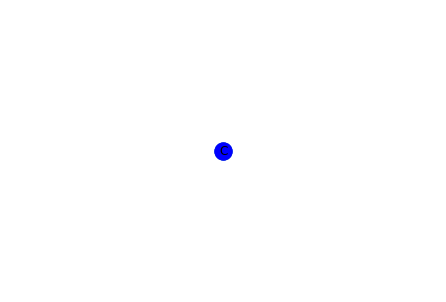

tensor([0.2437, 0.7563])


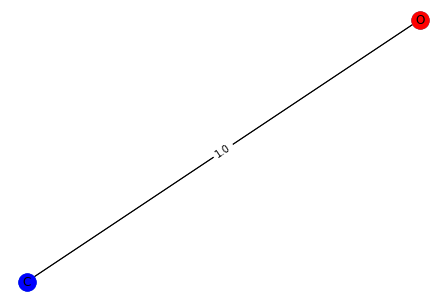

tensor([0.2180, 0.7820])


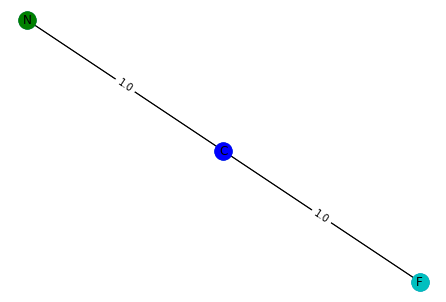

tensor([0.4255, 0.5745])


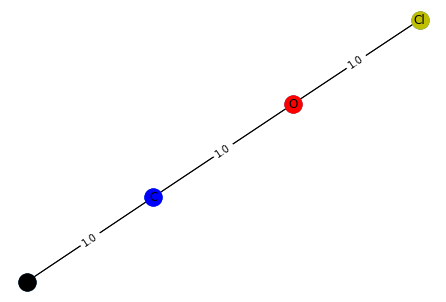

tensor([0.1308, 0.8692])


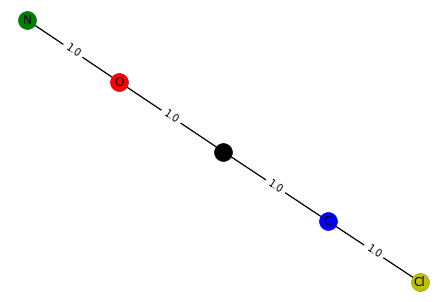

tensor([0.1110, 0.8890])


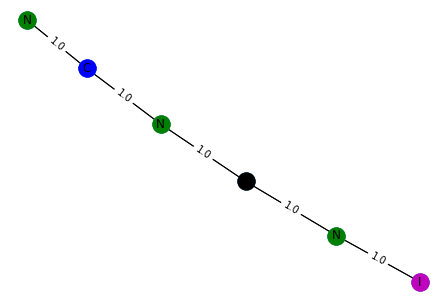

tensor([0.1127, 0.8873])


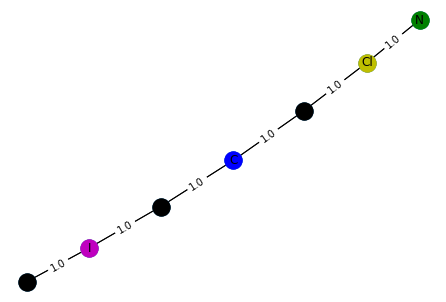

tensor([0.0923, 0.9077])


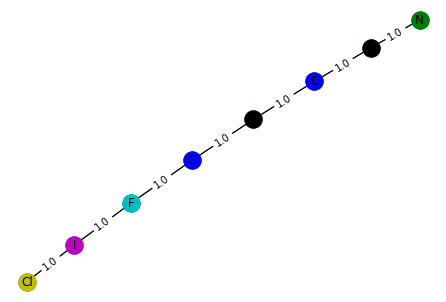

tensor([0.1742, 0.8258])


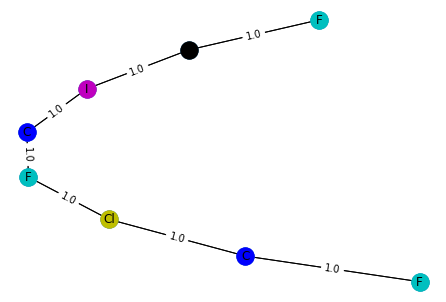

tensor([0.1783, 0.8217])


In [60]:
for i in range(1, 10):
  g.reset_graph()
  train_generator(c=1, initial_node=0, max_nodes=i)
  to_display = generate_graph(c=1,max_nodes=i)
  display_graph(to_display)
  print(g.model(to_display['feat'],to_display['adj'],None))